<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/samples/MNIST_TPU_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FastAI XLA Extensions MNIST Demo


## How to use

### Configure the Pytorch XLA package 

The Pytorch xla package requires an environment supporting TPUs (Kaggle kernels, GCP or Colab environments required)

If running on Colab, make sure the Runtime Type is set to TPU.


In [1]:
#hide_input
#colab
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [2]:
#hide
#colab
!curl -s https://course19.fast.ai/setup/colab | bash 

Updating fastai...
Done.


Install fastai2 and the fastai_xla_extensions packages

In [3]:
!pip install -Uqq fastcore --upgrade

In [4]:
!pip install -Uqq fastai --upgrade

In [5]:
!pip install -Uqq fastai_xla_extensions

In [6]:
!pip install -Uqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl
# for nightly versions
# VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION

     |████████████████████████████████| 133.6MB 99kB/s 
     |████████████████████████████████| 61kB 3.3MB/s 


In [7]:
!pip freeze | grep torch
!pip freeze | grep fast

torch==1.7.0+cu101
torch-xla==1.7
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.1+cu101
fastai==2.1.9
fastai-xla-extensions==0.0.5
fastcore==1.3.12
fastdtw==0.3.4
fastprogress==1.0.0
fastrlock==0.5


### Import the libraries
Import the fastai2 and fastai_xla_extensions libraries

In [8]:
#colab
from fastai.vision.all import *
import fastai_xla_extensions.core

### Example
Build a MNIST classifier -- adapted from fastai course [Lesson 4 notebook](https://github.com/fastai/course-v4/blob/master/nbs/04_mnist_basics.ipynb)

Load MNIST dataset 

In [9]:
path = untar_data(URLs.MNIST)

In [10]:
#hide
Path.BASE_PATH = path

In [11]:
path.ls()

(#2) [Path('testing'),Path('training')]

Create Fastai DataBlock


_Note that batch transforms are currently
set to none as they seem to slow the training
on the TPU (for investigation)._

In [12]:
datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training',valid_name='testing'),
    get_y=parent_label,
    item_tfms=Resize(28),
    batch_tfms=aug_transforms(do_flip=False, min_scale=0.9)
)

In [13]:
#colab
# datablock.summary(path)

Create the dataloader

In [14]:
dls = datablock.dataloaders(path,bs=256)

In [15]:
dls.device

device(type='cpu')

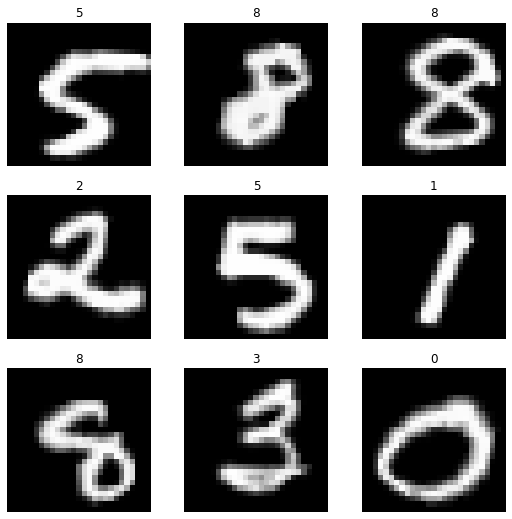

In [16]:
dls.show_batch()

Create a Fastai CNN Learner

In [17]:
learner = cnn_learner(dls, resnet18, metrics=accuracy)
                      

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [18]:
learner.to_xla()

In [19]:
learner.dls.device

In [20]:
learner.xla_opt

XLAOptCallback

In [21]:
# learner.fit(1,1e-3)

Using the `lr_find` works 

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.0063095735386013985)

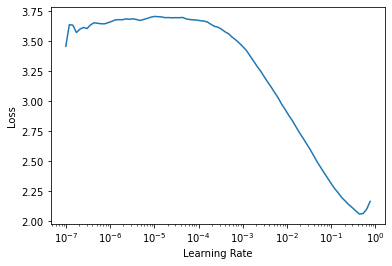

In [22]:
#colab
learner.lr_find()

Fine tune model


In [23]:
#colab
learner.fine_tune(1, base_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.682512,0.464777,0.847000,02:10


epoch,train_loss,valid_loss,accuracy,time
0,0.087883,0.061080,0.981900,02:13


Unfreeze the model

In [24]:
#colab
learner.unfreeze()

Run the LR Finder again. 


SuggestedLRs(lr_min=8.31763736641733e-07, lr_steep=6.309573450380412e-07)

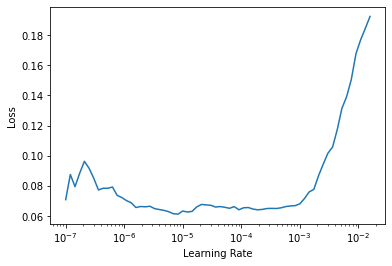

In [25]:
#colab
learner.lr_find()

Further fine-tuning

In [26]:
#colab
learner.fit_one_cycle(1,slice(1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.067538,0.057873,0.982500,02:02


In [27]:
#hide
#colab
learner.save('stage-1')

Path('models/stage-1.pth')

In [28]:
#hide
#colab
learner.load('stage-1')

Model params are using TPU

In [29]:
#colab
one_param(learner.model).device


device(type='xla', index=1)

Dataloader device is None _(DeviceMoverTransform)_ is actually the one moving the batch input to the TPU

In [30]:
#colab
learner.dls.device is None

True

In [31]:
#colab
learner.dls.train.after_batch.fs

(#6) [IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: (TensorImage,object) -> decodes
,Warp -- {'magnitude': 0.2, 'p': 1.0, 'draw_x': None, 'draw_y': None, 'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'batch': False, 'align_corners': True, 'mode_mask': 'nearest'}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ,RandomResizedCropGPU -- {'size': None, 'min_scale': 0.9, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
decodes: ,DeviceMoverTransform -- {'device_to': device(type='xla', index=1), 'device_from': device(type='cpu')}:
encodes: (Tensor,object) -> encodes
decodes: (Tensor,object) -> decodes
,Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
encodes: (TensorImage,object) -> encodes
decodes: ,Normalize -

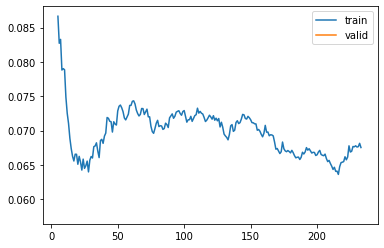

In [32]:
learner.recorder.plot_loss()

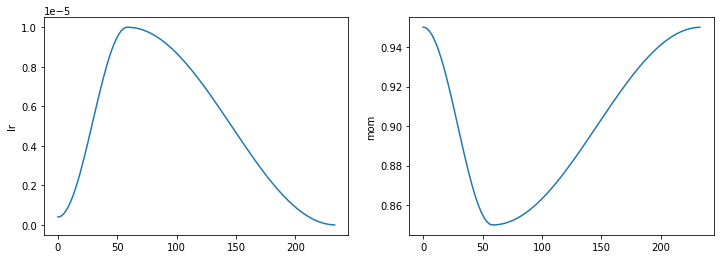

In [33]:
#colab
learner.recorder.plot_sched()

Plot loss seems to be working fine.

In [34]:
interp = ClassificationInterpretation.from_learner(learner)

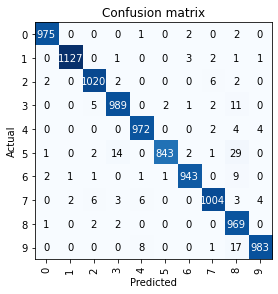

In [35]:
interp.plot_confusion_matrix()

In [36]:
interp.most_confused(4)

[('5', '8', 29),
 ('9', '8', 17),
 ('5', '3', 14),
 ('3', '8', 11),
 ('6', '8', 9),
 ('9', '4', 8),
 ('2', '7', 6),
 ('7', '2', 6),
 ('7', '4', 6),
 ('3', '2', 5),
 ('4', '8', 4),
 ('4', '9', 4),
 ('7', '9', 4)]

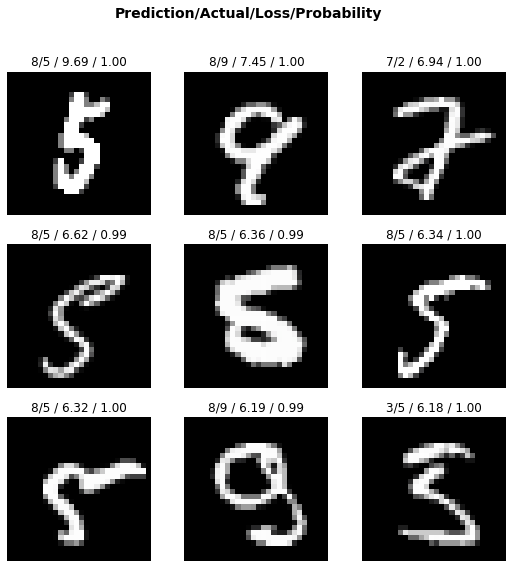

In [37]:
interp.plot_top_losses(9)